In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import time

In [3]:
nrg = pd.read_csv('../data/all_erco_energy_cst.csv',index_col='datetime')
# fcast = pd.read_csv('../data/erco_forecast.csv',index_col='datetime')

In [4]:
nrg.head(2)

,demand,plant,net_generation,coal,hydro,natural_gas,nuclear,other,solar,wind,total_interchange,forecast
datetime,,,,,,,,,,,,
20220206T11-06,49854.0,ERCO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52270.0
20220206T10-06,53017.0,ERCO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55237.0


<AxesSubplot:title={'center':'Moving Average'}, xlabel='datetime'>

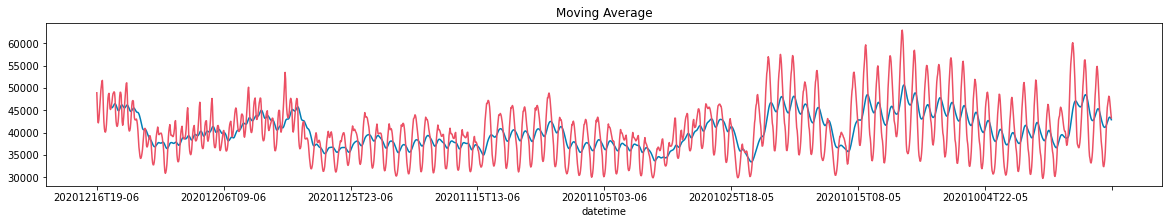

In [5]:
nrg['demand'][10000:12000].rolling(30).mean().plot(figsize=(20,3), kind='line',title='Moving Average',color='#007EB5')
nrg['demand'][10000:12000].plot(figsize=(20,3), kind='line', color='#EC5064')

Model 1 - Moving Average model: takes an average of the 30 data points(hours) to predict the next hour's demand. Does not match peaks and troughs well.

In [6]:
nrg = nrg.dropna()

In [7]:
d = nrg['demand']

In [8]:
cols = len(d) #Data Science for Supply Chain Management by Nicolas Vandepunt

d = np.append(d,[np.nan]*1)

f,a,b = np.full((3, cols+1),np.nan)

a[0] = d[0]

b[0] = d[1] -d[0]

for t in range(1,cols):
    f[t] = a[t-1] + b[t-1]
    a[t] = 0.4*d[t] + (1-0.4)*(a[t-1]+b[t-1])
    b[t] = 0.2*(a[t]-a[t-1]) + (1-0.2)*b[t-1]

for t in range(cols, cols+1):
    f[t] = a[t-1] + b[t-1]
    a[t] = f[t]
    b[t] = b[t-1]

df_three = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Level':a, 'Trend':b,'Error':d-f})

<AxesSubplot:title={'center':'Exp Smoothing'}>

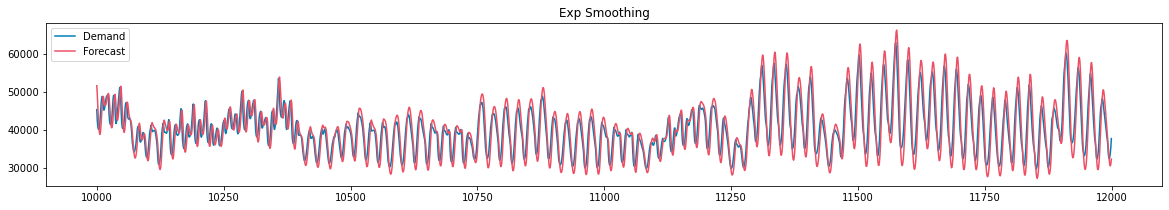

In [9]:
df_three[['Demand','Forecast']][10000:12000].plot(figsize=(20,3), kind='line',title='Exp Smoothing',color=['#007EB5','#EC5064'])

Model 2 - Simple Exponential Smoothing: Model fits better than moving average but does not account for seasonality. The bias is -0.34, MAE: 3386, and RMSE: 4189.

In [21]:
mae_function(df_three)

Bias: -0.34, -0.00%
MAE: 3385.78, 7.68%
RMSE: 4188.94, 9.50%


In [10]:
def mae_function(df):
    ###From Data Science for Supply Chain Management by Nicolas Vandepunt###
    dem_ave = df.loc[df['Error'].notnull(), 'Demand'].mean()
    bias_abs = df['Error'].mean()
    bias_rel = bias_abs / dem_ave
    print('Bias: {:0.2f}, {:.2%}'.format(bias_abs,bias_rel))
    mae_abs = df['Error'].abs().mean()
    mae_rel = mae_abs / dem_ave
    print('MAE: {:0.2f}, {:.2%}'.format(mae_abs,mae_rel))
    rmse_abs = np.sqrt((df['Error']**2).mean())
    rmse_rel = rmse_abs / dem_ave
    print('RMSE: {:0.2f}, {:.2%}'.format(rmse_abs,rmse_rel))

In [11]:
def seasonal_factors_mul(s,d,slen,cols):
    for i in range(slen):
        s[i] = np.mean(d[i:cols:slen])
    s /= np.mean(s[:slen])
    return s

In [12]:
def exp_smooth_funct(d, slen=12, extra_periods=1, alpha=0.4, beta=0.4, phi=0.9, gamma=0.3):
###Data Science for Supply Chain Management by Nicolas Vandepunt###
    cols = len(d)
    
    d = np.append(d,[np.nan]*extra_periods)
    
    f,a,b,s = np.full((4, cols+extra_periods), np.nan)
    s = seasonal_factors_mul(s,d,slen,cols)
    
    a[0] = d[0]/s[0]
    b[0] = d[1]/s[1] - d[0]/s[0]

    for t in range(1,slen):
        f[t] = (a[t-1] + phi*b[t-1])*s[t]
        a[t] = alpha*d[t]/s[t] + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]
        
        
        
    for t in range(slen,cols):
        f[t] = (a[t-1] + phi*b[t-1]) * s[t-slen]
        a[t] = alpha * d[t]/s[t-slen] + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]
        s[t] = gamma*d[t]/a[t] + (1-gamma)*s[t-slen]
        
                
                
    for t in range(cols,cols+extra_periods):
        f[t] = (a[t-1] + phi*b[t-1])*s[t-slen]
        a[t] = f[t]/s[t-slen]
        b[t] = phi*b[t-1]
        s[t] = s[t-slen]

    df_funct = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Level':a, 'Trend':b,'Season':s,'Error':d-f})
    return df_funct

In [13]:
nrg_dem = nrg['demand']

In [14]:
tri_exp = exp_smooth_funct(nrg_dem, slen=12000, extra_periods=1, alpha=0.4, beta=0.4, phi=0.8, gamma=0.2)

In [15]:
tri_exp.shape

(31461, 6)

<AxesSubplot:title={'center':'Triple Exp Smoothing'}>

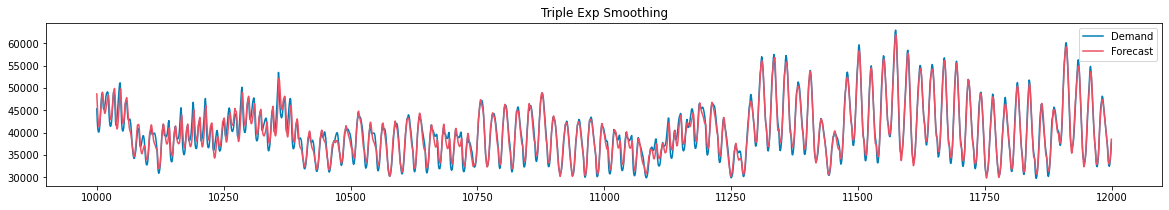

In [16]:
tri_exp[['Demand','Forecast']][10000:12000].plot(figsize=(20,3), kind='line',title='Triple Exp Smoothing',color=['#007EB5','#EC5064'])

Model 3 - Triple Exponential Smoothing: Takes exponential smoothing and introduces seasonailty parameter. The bias is -0.93, MAE: 1337, and RMSE: 1687.

In [17]:
mae_function(tri_exp)

Bias: -0.93, -0.00%
MAE: 1337.39, 3.03%
RMSE: 1687.98, 3.83%


In [18]:
tri_exp.shape

(31461, 6)

In [19]:
tri_exp.notnull().shape

(31461, 6)

In [20]:
tri_exp

,Demand,Forecast,Level,Trend,Season,Error
0,51910.0,NaN,52013.663869,-976.914964,0.998007,NaN
1,52424.0,52624.693779,51153.978701,-812.793250,1.027181,-200.693779
2,52723.0,52788.768409,50478.575483,-660.302047,1.045245,-65.768409
3,52136.0,52375.841315,49858.840107,-564.839133,1.048558,-239.841315
4,50843.0,51382.429458,49199.492629,-534.861775,1.039983,-539.429458
...,...,...,...,...,...,...
31456,41776.0,37506.125723,46603.199635,207.729000,0.852441,4269.874277
31457,43206.0,38273.522750,49180.333281,1130.563378,0.830381,4932.477250
31458,45279.0,40938.825180,52208.701486,1754.017704,0.827366,4340.174820
31459,48214.0,44750.632056,55271.581951,2067.080684,0.842234,3463.367944
